<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
<br />
Илья, привет! И на ревью мне достался твой проект. здорово. Пошёл смотерть...<br>
Первую часть уже смотерел - перейду сразу ко второй)

<div class="alert alert-info"> <b>Комментарий студента:</b> Привет) Ниже построил график с факторами))</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
<font color='green'><br>Привет, Илья! ОК, пошёл смотреть...

# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Ковш облицовывают огнеупорным кирпичом, чтобы он выдержал высокие температуры;
2. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша;
3. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.
4. Сталь легируют - изменяют состав - подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат(traib-масса);

Основа:

5. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ;
6. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения;
7. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки;
8. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки;
9. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

1. Загрузим и подготовим данные: изменим тип данных, везде разное количество партий, решим какие партии использовать.
2. Соединим все таблицы в одну и выделим target и features.
3. Задача регрессии, поэтому выберем определенные модели LinearRegression, RandomForestRegressor, CatBoostRegressor и другие.
4. Обучим каждую модель и протестируем;
5. Выберем лучший показатель с наименьшей средней ошибкой.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pyod.models.knn import KNN
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### Данные об электродах

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Напишем функцию для просмотра значений каждого столбца.

In [3]:
def info(data):
    for column in data.columns:
        print('Уникальные значения столбца', column)
        print(data[column].sort_values().unique())

In [4]:
info(data_arc)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Начало нагрева дугой
['2019-05-03 11:02:14' '2019-05-03 11:07:28' '2019-05-03 11:11:44' ...
 '2019-09-01 04:16:41' '2019-09-01 04:31:51' '2019-09-01 04:34:47']
Уникальные значения столбца Конец нагрева дугой
['2019-05-03 11:06:02' '2019-05-03 11:10:33' '2019-05-03 11:14:36' ...
 '2019-09-01 04:19:45' '2019-09-01 04:32:48' '2019-09-01 04:36:08']
Уникальные значения столбца Активная мощность
[0.03000194 0.03018816 0.0301905  ... 3.15076178 3.15627646 3.73159611]
Уникальные значения столбца Реактивная мощность
[-7.15504924e+02  2.08063126e-02  2.11541653e-02 ...  2.45995915e+00
  2.50420606e+00  2.67638755e+00]


В реактивной мощности есть отрицательное значение. Посмотрим график только с положительными.

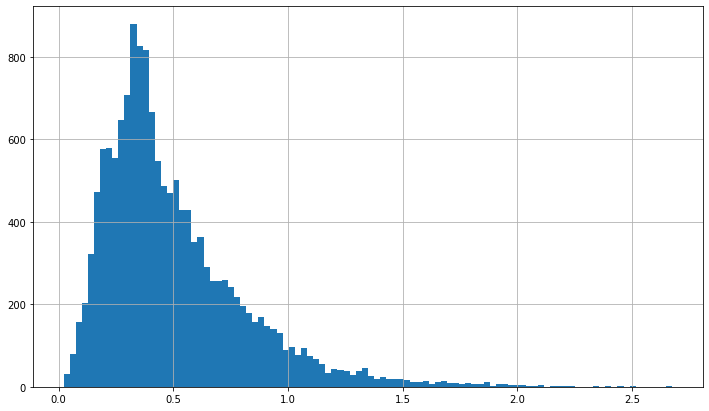

In [5]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(12,7))

In [6]:
#уникальные значения партий
len(data_arc['key'].unique())

3214

### Данные о подаче сыпучих материалов (объём)

In [7]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [8]:
info(data_bulk)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Bulk 1
[ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]
Уникальные значения столбца Bulk 2
[228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]
Уникальные значения столбца Bulk 3
[  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 1

In [9]:
for column in data_bulk.columns:
    print(column)
    display(data_bulk[column].describe())

key


count    3129.000000
mean     1624.383509
std       933.337642
min         1.000000
25%       816.000000
50%      1622.000000
75%      2431.000000
max      3241.000000
Name: key, dtype: float64

Bulk 1


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

Bulk 2


count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

Bulk 3


count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

Bulk 4


count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

Bulk 5


count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

Bulk 6


count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

Bulk 7


count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

Bulk 8


count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

Bulk 9


count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

Bulk 10


count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

Bulk 11


count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

Bulk 12


count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

Bulk 13


count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

Bulk 14


count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

Bulk 15


count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

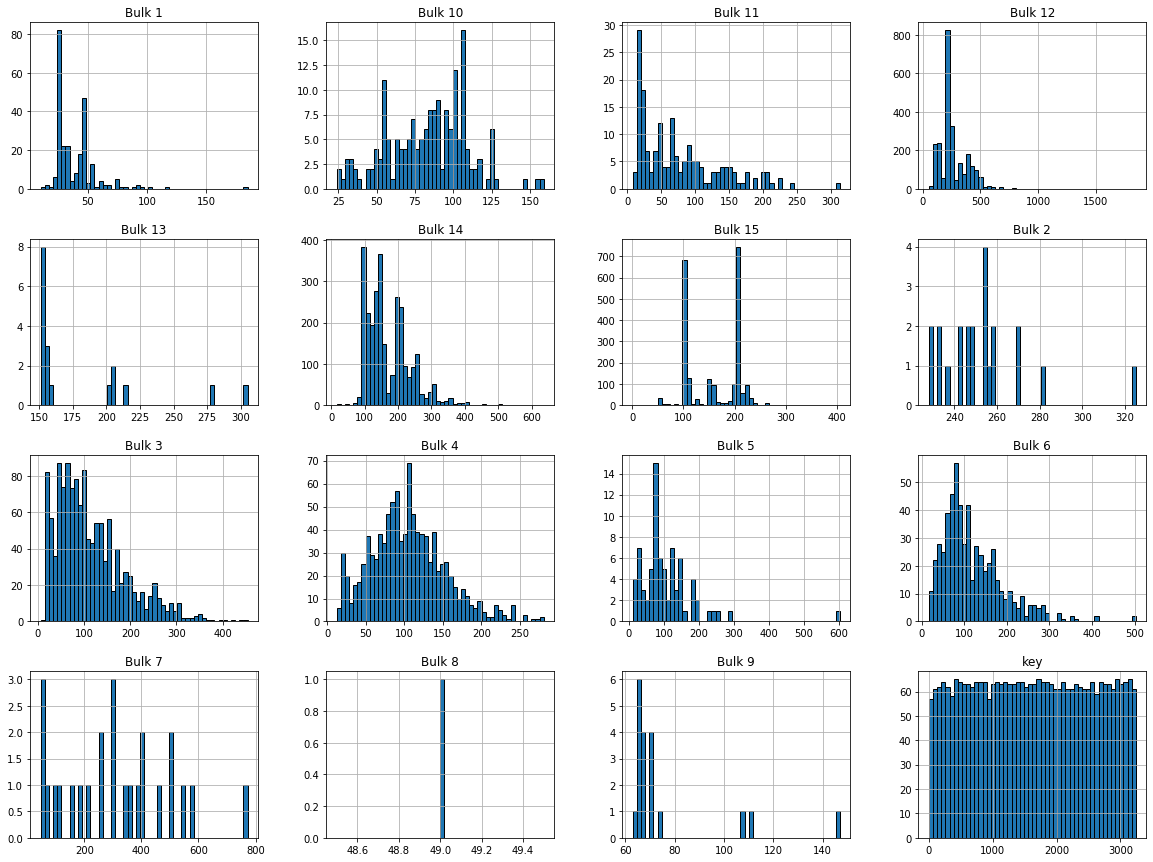

In [10]:
data_bulk.hist(bins=50, figsize=(20,15), edgecolor='black')
plt.show()

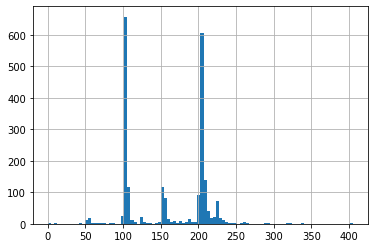

In [11]:
data_bulk[column].hist(bins=100)

In [12]:
#уникальные значения партий
len(data_bulk['key'].unique())

3129

### Данные о подаче сыпучих материалов (время)

In [13]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
info(data_bulk_time)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Bulk 1
['2019-05-03 17:50:19' '2019-05-05 10:09:13' '2019-05-05 11:01:42'
 '2019-05-05 11:59:23' '2019-05-05 13:13:45' '2019-05-05 14:17:04'
 '2019-05-05 15:03:54' '2019-05-05 16:00:33' '2019-05-05 20:49:32'
 '2019-05-07 11:24:41' '2019-05-07 15:37:52' '2019-05-07 16:15:34'
 '2019-05-07 17:35:13' '2019-05-08 01:00:11' '2019-05-08 05:26:23'
 '2019-05-08 10:05:03' '2019-05-08 10:39:56' '2019-05-08 11:33:17'
 '2019-05-08 15:14:16' '2019-05-09 04:35:17' '2019-05-10 16:46:26'
 '2019-05-10 17:16:52' '2019-05-10 18:41:05' '2019-05-10 20:05:32'
 '2019-05-11 10:46:17' '2019-05-11 12:15:55' '2019-05-11 17:50:54'
 '2019-05-12 15:36:08' '2019-05-12 16:43:26' '2019-05-12 21:33:11'
 '2019-05-13 13:14:48' '2019-05-13 14:36:57' '2019-05-14 12:01:34'
 '2019-05-14 14:09:52' '2019-05-14 16:24:02' '2019-05-14 21:58:07'
 '2019-05-15 09:27:40' '2019-05-15 15:05:04' '2019-05-15 21:42:31'
 '2019-05-15 23:52:57' '20

In [15]:
len(data_bulk_time['key'].unique())

3129

### Данные о продувке сплава газом

In [16]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [17]:
info(data_gas)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Газ 1
[8.39852910e-03 1.66956024e-02 2.63028954e-01 ... 5.21423726e+01
 6.09356892e+01 7.79950397e+01]


In [18]:
len(data_gas['key'].unique())

3239

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

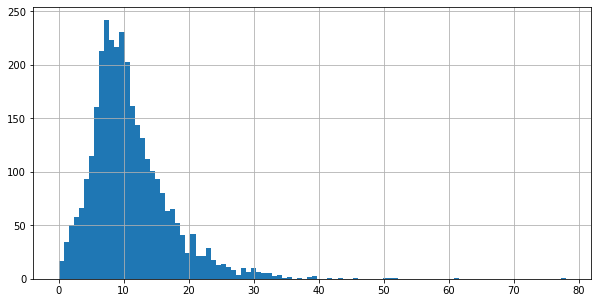

In [19]:
data_gas['Газ 1'].hist(bins=100, figsize=(10,5))
data_gas['Газ 1'].describe()

### Результаты измерения температуры

In [20]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [21]:
info(data_temp)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Время замера
['2019-05-03 11:16:18' '2019-05-03 11:25:53' '2019-05-03 11:29:11' ...
 '2019-09-01 04:22:39' '2019-09-01 04:33:42' '2019-09-01 04:38:08']
Уникальные значения столбца Температура
[1191. 1204. 1208. 1218. 1227. 1383. 1519. 1520. 1525. 1526. 1527. 1528.
 1529. 1530. 1531. 1532. 1533. 1534. 1535. 1536. 1537. 1538. 1539. 1540.
 1541. 1542. 1543. 1544. 1545. 1546. 1547. 1548. 1549. 1550. 1551. 1552.
 1553. 1554. 1555. 1556. 1557. 1558. 1559. 1560. 1561. 1562. 1563. 1564.
 1565. 1566. 1567. 1568. 1569. 1570. 1571. 1572. 1573. 1574. 1575. 1576.
 1577. 1578. 1579. 1580. 1581. 1582. 1583. 1584. 1585. 1586. 1587. 1588.
 1589. 1590. 1591. 1592. 1593. 1594. 1595. 1596. 1597. 1598. 1599. 1600.
 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610. 1611. 1612.
 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622. 1623. 1624.
 1625. 1626. 1627. 1628. 1629. 1630. 1631. 1632. 1633. 

In [22]:
len(data_temp['key'].unique())

3216

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

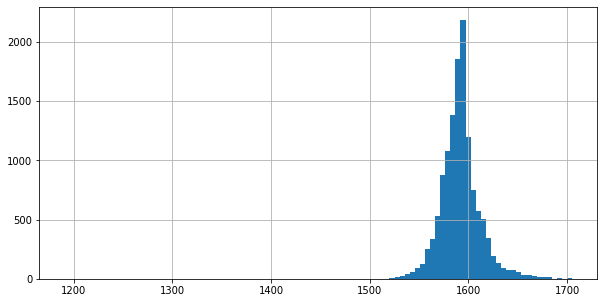

In [23]:
data_temp['Температура'].hist(bins=100, figsize=(10,5))
data_temp['Температура'].describe()

### Данные о проволочных материалах (объём)

In [24]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [25]:
info(data_wire)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Wire 1
[  1.9188     2.09664    3.10128  ... 280.987214 330.314424        nan]
Уникальные значения столбца Wire 2
[3.01600000e-02 6.03200000e-02 9.04800000e-02 9.04800000e-02
 1.74720000e-01 5.82400000e-01 1.17624000e+00 1.60160000e+00
 2.74456000e+00 3.98112000e+00 4.10176000e+00 4.13192000e+00
 5.12720000e+00 7.72096000e+00 8.08288000e+00 8.11304000e+00
 8.17336000e+00 8.83688000e+00 9.01784000e+00 9.04800000e+00
 9.07816000e+00 9.08544100e+00 9.10832000e+00 9.11456000e+00
 9.13848000e+00 9.14368100e+00 9.16864000e+00 9.19880000e+00
 9.22896000e+00 9.31944000e+00 9.68136000e+00 1.00432800e+01
 1.00734400e+01 1.01036000e+01 1.01337590e+01 1.01337600e+01
 1.01639190e+01 1.01940790e+01 1.02242400e+01 1.10385600e+01
 1.10687200e+01 1.10988800e+01 1.11238400e+01 1.11290400e+01
 1.11592000e+01 1.11893600e+01 1.12195200e+01 1.20338400e+01
 1.20848000e+01 1.20941600e+01 1.21243200e+01 1.21430400e+

In [26]:
for column in data_wire.columns:
    print(column)
    display(data_wire[column].describe())

key


count    3081.000000
mean     1623.426485
std       932.996726
min         1.000000
25%       823.000000
50%      1619.000000
75%      2434.000000
max      3241.000000
Name: key, dtype: float64

Wire 1


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060484
max       330.314424
Name: Wire 1, dtype: float64

Wire 2


count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

Wire 3


count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

Wire 4


count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

Wire 5


count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

Wire 6


count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

Wire 7


count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

Wire 8


count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

Wire 9


count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

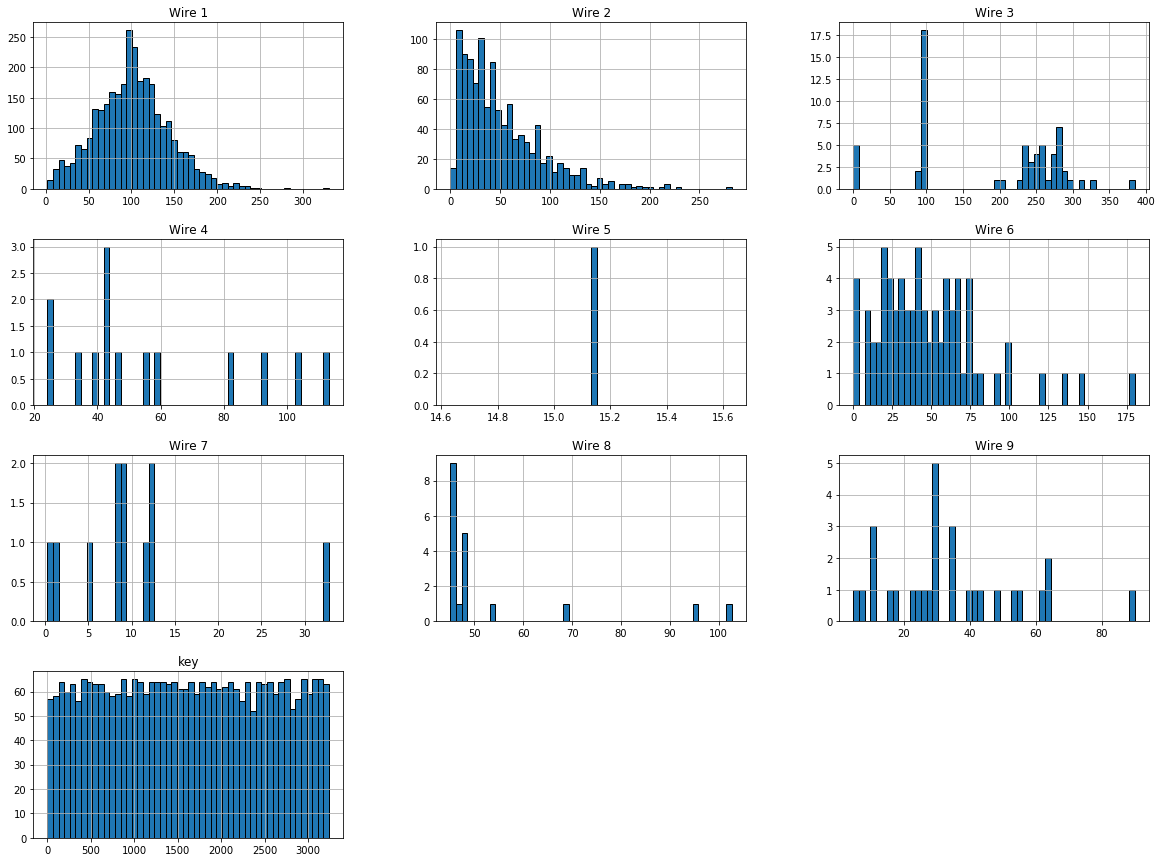

In [27]:
data_wire.hist(bins=50, figsize=(20,15), edgecolor='black')
plt.show()

In [28]:
len(data_wire['key'].unique())

3081

### Данные о проволочных материалах (время)

In [29]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [30]:
info(data_wire_time)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Wire 1
['2019-05-03 11:11:41' '2019-05-03 11:46:10' '2019-05-03 12:13:47' ...
 '2019-09-01 03:12:02' '2019-09-01 04:16:01' nan]
Уникальные значения столбца Wire 2
['2019-05-03 13:32:06' '2019-05-03 13:59:54' '2019-05-03 15:58:12' ...
 '2019-08-31 13:14:22' '2019-08-31 18:50:15' nan]
Уникальные значения столбца Wire 3
['2019-05-04 04:47:53' '2019-05-04 05:40:08' '2019-05-07 08:50:29'
 '2019-05-07 10:17:14' '2019-05-07 15:50:31' '2019-05-07 16:34:12'
 '2019-05-07 17:43:23' '2019-05-07 21:58:49' '2019-05-07 22:40:07'
 '2019-05-07 23:27:46' '2019-05-18 13:04:48' '2019-05-18 13:41:36'
 '2019-05-18 20:52:18' '2019-05-18 21:49:12' '2019-06-02 20:37:44'
 '2019-06-08 16:23:31' '2019-06-10 13:19:54' '2019-06-10 14:05:33'
 '2019-06-10 14:25:42' '2019-06-12 01:29:02' '2019-06-12 20:11:25'
 '2019-06-12 21:27:01' '2019-07-07 18:33:17' '2019-07-07 19:25:35'
 '2019-07-07 20:16:17' '2019-07-08 17:20:59' '201

In [31]:
len(data_wire_time['key'].unique())

3081

### Вывод:

1. Нужно изменить тип данных в столбцах таблице data_bulk с float на int, в столбцах даты на datetime, в столбцах температуры так же изменить на int;
2. Название столбцов изменить на английский;
3. Есть пропуски в значениях. Возможно ошибка в данных, либо отсутсвие выполнения действий на этапе обработки.
4. У каждой таблицы разное количество партий(key). Это связанно с тем, что некоторые этапы обработки могут повторяться, таким образом увеличивается кол-во партий.
5. В таблице data_arc есть аномально значени в столбце "Реактивная мощность" отрицательное значение.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
Кажется на этом в прошлый раз остановились... идём дальше)

## Подготовка данных

1. Найдем суммы значений активной и реактивной мощности
2. Cоздадим новую таблицу из первого и последнего замера температуры
3. Значения столбца key переведем в индексы датафреймов.
4. Заполним nan значения 0 для таблиц data_bulk и data_wire.
5. Приведем типы данных для ускорения работы.
6. Разобьем данные на train/test в соотношении 75/25.

Составим из таблицы data_arc сгрупированную таблицу data_arc_sum по key для дальнейшего объединения данных.

In [32]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_arc = data_arc.query('reactive_power > 0')
data_arc_sum = pd.pivot_table(data_arc, index='key',
                              values=['active_power', 'reactive_power'], 
                              aggfunc = {'active_power' : sum,
                                         'reactive_power' : sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum.head()

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


Удалим партии, где нет значения последней температуры и где есть только одно измерение температуры:

In [33]:
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['Время замера'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['Время замера'].max() == 
            data_temp[data_temp['key'] == key]['Время замера'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys, len(bad_keys))

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 195, 213, 216, 220, 222, 267, 271, 279, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2522, 2540, 2543, 2544, 2572, 2601, 2604, 2606, 2667, 2670, 2671, 2695, 2698, 2736, 2743, 2787, 2808, 2809, 2814, 2838, 2842, 2843, 2862, 2898, 2951, 2960, 2988, 3044, 3047, 3146, 3153, 3156, 3187, 3204, 3209, 3211, 3212, 3216] 171


Оставим партии, где нет ошибок и удалим все пропуски

In [34]:
data_temp = data_temp.query('key != @bad_keys')
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12381 entries, 0 to 15902
Data columns (total 3 columns):
key             12381 non-null int64
Время замера    12381 non-null object
Температура     12381 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 386.9+ KB


In [35]:
count_of_bad_keys = (data_temp['key'].value_counts() < 2).sum() 
good_keys = list(data_temp['key'].value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')
data_temp['key'].value_counts()

1214    16
44      16
1513    16
46      16
1689    15
        ..
1211     2
1801     2
151      2
1836     2
1736     2
Name: key, Length: 2344, dtype: int64

Создадим таблицу с временем начального и конечного измерения температуры

In [36]:
data_temp.columns = ['key', 'time','temp']
data_temp_pt = pd.pivot_table(data_temp, 
                              values='time',
                              index='key',
                              aggfunc={'time': [np.min, np.max]})
data_temp_pt.head()

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19


Теперь сформируем данные на основе времени и сохраним их в data_temp_final.

In [37]:
start_time_list = list(data_temp_pt['amin'])
end_time_list = list(data_temp_pt['amax'])
data_temp_start = data_temp.query('time == @start_time_list').set_index('key')
data_temp_end = data_temp.query('time == @end_time_list').set_index('key')
data_temp_final = data_temp_start.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end['temp']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
да!!!! это важный момент проекта

Для объединения нам потребуются датафреймы data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. В каждой таблице преобразуем index в значение столбца key.

In [38]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

Будем предсказывать целевой признак - end_temp. Удалим партии, где нет информации о температуре. Столбец wire_5 удалим из-за отсуствия информации во всех запясях.

In [39]:
data_steel = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_steel = data_steel.dropna(subset=['end_temp'])
data_steel.info()
data_steel = data_steel.drop('wire_5',axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 29 columns):
sum_active_power      2344 non-null float64
sum_reactive_power    2344 non-null float64
start_temp            2344 non-null float64
end_temp              2344 non-null float64
bulk_1                189 non-null float64
bulk_2                13 non-null float64
bulk_3                931 non-null float64
bulk_4                758 non-null float64
bulk_5                53 non-null float64
bulk_6                433 non-null float64
bulk_7                13 non-null float64
bulk_8                1 non-null float64
bulk_9                13 non-null float64
bulk_10               130 non-null float64
bulk_11               124 non-null float64
bulk_12               1797 non-null float64
bulk_13               13 non-null float64
bulk_14               2043 non-null float64
bulk_15               1633 non-null float64
gas                   2342 non-null float64
wire_1                2227 non-n

Приведем типы столбцов start_temp, end_temp и bulk к целому типу int, так как там храняться только целые числа. Заранее во все NaN разместим значения 0.

In [40]:
data_steel = data_steel.fillna(0)
data_steel['start_temp'] = data_steel['start_temp'].astype('int16')
data_steel['end_temp'] = data_steel['end_temp'].astype('int16')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = data_steel[f'bulk_{i}'].astype('int16')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 28 columns):
sum_active_power      2344 non-null float64
sum_reactive_power    2344 non-null float64
start_temp            2344 non-null int16
end_temp              2344 non-null int16
bulk_1                2344 non-null int16
bulk_2                2344 non-null int16
bulk_3                2344 non-null int16
bulk_4                2344 non-null int16
bulk_5                2344 non-null int16
bulk_6                2344 non-null int16
bulk_7                2344 non-null int16
bulk_8                2344 non-null int16
bulk_9                2344 non-null int16
bulk_10               2344 non-null int16
bulk_11               2344 non-null int16
bulk_12               2344 non-null int16
bulk_13               2344 non-null int16
bulk_14               2344 non-null int16
bulk_15               2344 non-null int16
gas                   2344 non-null float64
wire_1                2344 non-null float64
wir

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ок, чётко.

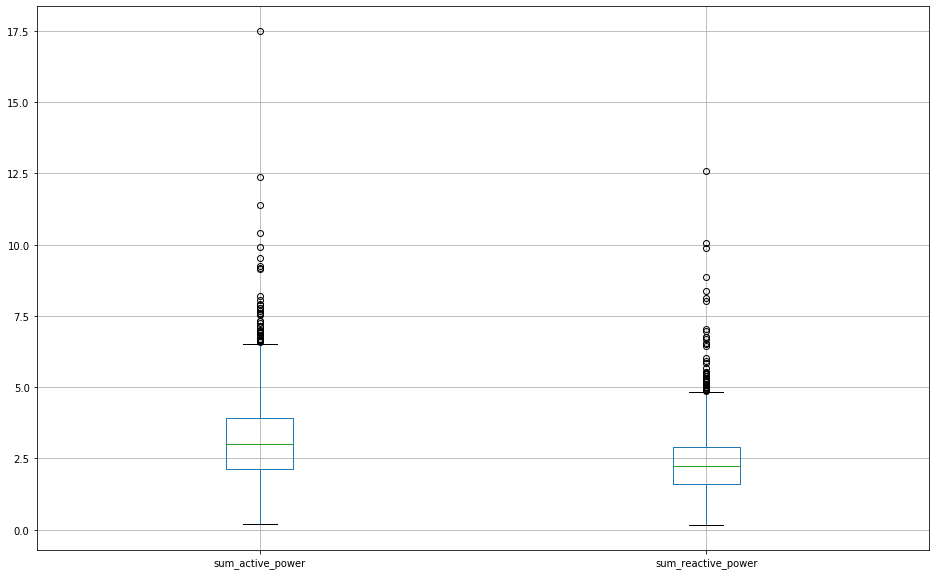

In [41]:
data_steel.boxplot(column=['sum_active_power','sum_reactive_power'], figsize=(16,10))
plt.show()

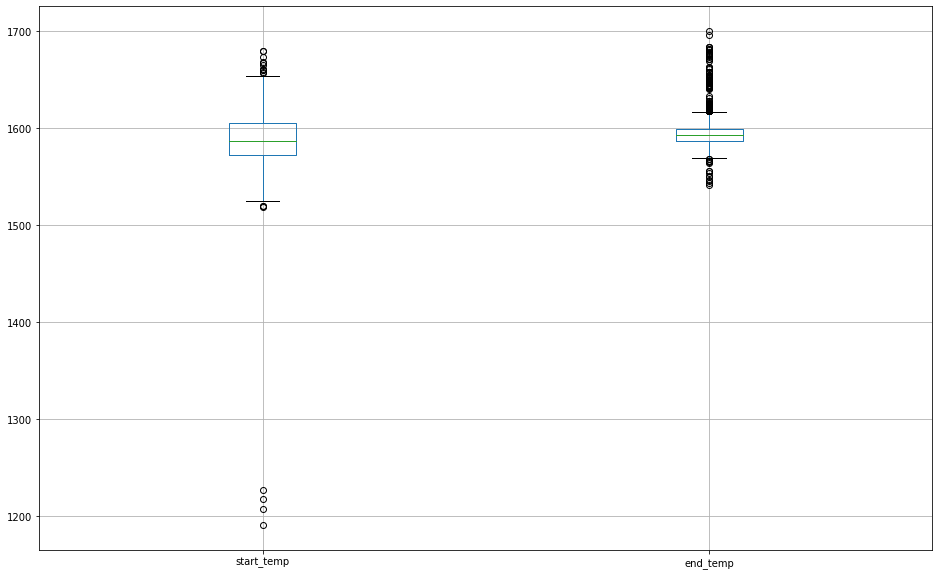

In [42]:
data_steel.boxplot(column=['start_temp','end_temp'], figsize=(16,10))
plt.show()

Выполним оценку мультиколлинеарности и посмотрим зависимости между признаками.

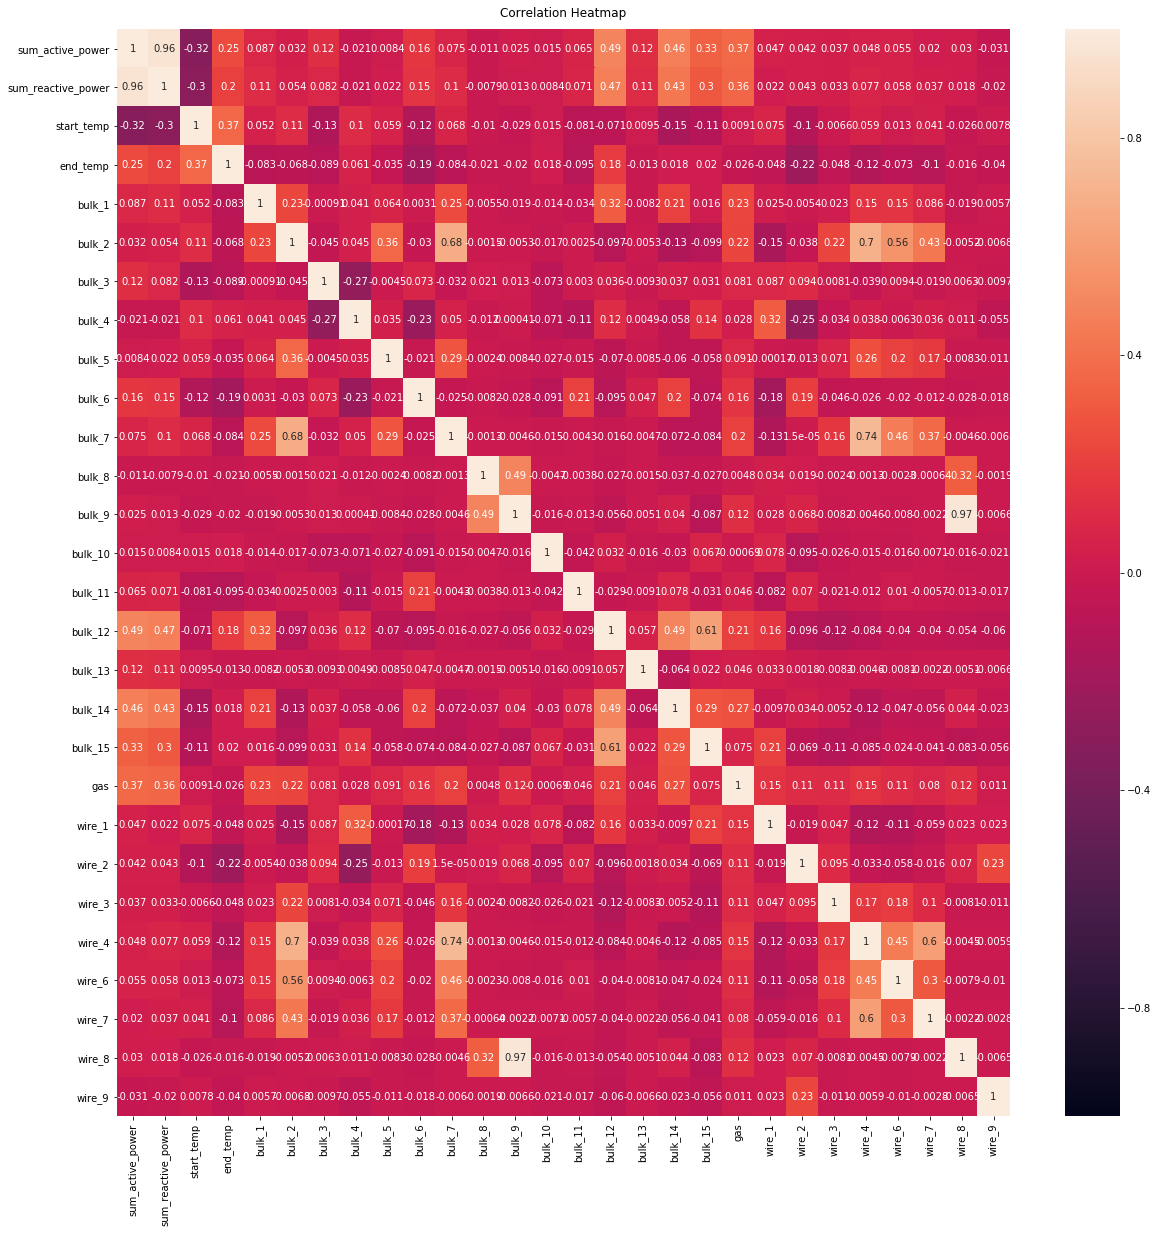

In [43]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(data_steel.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

На графике heatmap видно, что есть сильные зависимости между sum_active_power и sum_reactive_power, bulk_9 и wire_8. Так как они дублируют по сути друг друга, удалим из обучения sum_reactive_power и wire_8.

In [44]:
data_steel_knn = data_steel.copy()
data_steel_knn = data_steel_knn.drop(['sum_reactive_power', 'wire_8'], axis=1)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>есть контакт)

Посмотрим, какие столбцы влияют на результат end_temp.

In [45]:
data_steel_knn.corr()['end_temp']

sum_active_power    0.247650
start_temp          0.366398
end_temp            1.000000
bulk_1             -0.082638
bulk_2             -0.067612
bulk_3             -0.088806
bulk_4              0.061157
bulk_5             -0.034697
bulk_6             -0.188054
bulk_7             -0.084039
bulk_8             -0.021390
bulk_9             -0.020254
bulk_10             0.018222
bulk_11            -0.095105
bulk_12             0.180171
bulk_13            -0.012884
bulk_14             0.017625
bulk_15             0.019843
gas                -0.025723
wire_1             -0.048129
wire_2             -0.215639
wire_3             -0.048014
wire_4             -0.121044
wire_6             -0.073452
wire_7             -0.100990
wire_9             -0.039511
Name: end_temp, dtype: float64

Не все столбцы значимо влияют на данные. Для выявления аномалий возьмем те, чья корреляция больше 10%

In [46]:
data_steel_knn.corr()['end_temp'].abs() >= 0.1

sum_active_power     True
start_temp           True
end_temp             True
bulk_1              False
bulk_2              False
bulk_3              False
bulk_4              False
bulk_5              False
bulk_6               True
bulk_7              False
bulk_8              False
bulk_9              False
bulk_10             False
bulk_11             False
bulk_12              True
bulk_13             False
bulk_14             False
bulk_15             False
gas                 False
wire_1              False
wire_2               True
wire_3              False
wire_4               True
wire_6              False
wire_7               True
wire_9              False
Name: end_temp, dtype: bool

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>тоже вариант. А можно этот шаг оставить на потом - после моедлирования провести анализ важности факторов. Просто корреляция - сильно подвержена выбросам. Если его пропустить - можно сделать ложный вывод. А втрым способом - однозначно будет)

In [47]:
model = KNN()
data_steel_have_anomaly = data_steel_knn[['sum_active_power',
                                          'start_temp',
                                          'end_temp',
                                          'bulk_6',
                                          'bulk_12',
                                          'wire_2',
                                          'wire_4',
                                          'wire_7']]
model.fit(data_steel_have_anomaly)
data_steel_have_anomaly['is_outlier'] =  model.predict(data_steel_have_anomaly) == 1
outliers_knn = data_steel_have_anomaly['is_outlier'].sum()
print("Количество аномалий (KNN): ", outliers_knn)

outlier_indexes = list(data_steel_have_anomaly[data_steel_have_anomaly['is_outlier'] == 1].index)
good_indexes = list(set(data_steel_have_anomaly.index) - set(outlier_indexes))

data_steel_new = data_steel_knn.drop(outlier_indexes)
data_steel_new.shape

Количество аномалий (KNN):  196


(2148, 26)

### Вывод 

- удалили партии, где нет значения последней температуры и где есть только одно измерение температуры в таблице data_temp;
- пропуски nan заменили на значения 0 для таблиц data_bulk и data_wire;
- значения столбца key перевели в индексы;
- изменили тип данных в стобцах start_temp, end_temp, bulk_1-15 на int 16, чтобы ускорить процесс работы;
- после построения мультиколлинеарности, удалили из обучения sum_reactive_power и wire_8, так как есть сильные зависимости между sum_active_power и sum_reactive_power, bulk_9 и wire_8;
- так же выявили количество аномалий с помощью модели KNN и удалили их.

Целевым признаком является столбец end_temp.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ура, данные готовы) Хорошо проведена работа.

## Обучение моделей

Выберем модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

Для начало разобьем данные на выборки: train - 75%, test - 25%

In [48]:
features = data_steel_new.drop('end_temp', axis=1)
target = data_steel_new['end_temp']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=12345)

### LinearRegression

In [49]:
%%time

model = LinearRegression()
cv_mae_lr = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Средняя абсолютная ошибка LinearRegression =', cv_mae_lr)

Средняя абсолютная ошибка LinearRegression = 7.647884400270075
CPU times: user 110 ms, sys: 93.3 ms, total: 203 ms
Wall time: 128 ms


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ориентир..

### RandomForestRegressor

In [50]:
%%time

model = RandomForestRegressor()
hyperparams = [{'criterion' : ['mse'],
                'n_estimators' : [x for x in range(50, 500, 50)],
                'random_state' : [12345]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
cv_mae_rfr = (max(means) * -1)

best_params_rfr = clf.best_params_
print('Лучшие параметры:', clf.best_params_)
print('Средняя абсолютная ошибка RandomForestRegressor = ', cv_mae_rfr)

6.185164 for {'criterion': 'mse', 'n_estimators': 50, 'random_state': 12345}
6.155860 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 12345}
6.145189 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 12345}
6.146071 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 12345}
6.145381 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 12345}
6.135684 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 12345}
6.131429 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 12345}
6.128962 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 12345}
6.128377 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 12345}

Лучшие параметры: {'criterion': 'mse', 'n_estimators': 450, 'random_state': 12345}
Средняя абсолютная ошибка RandomForestRegressor =  6.128377129457207
CPU times: user 2min, sys: 729 ms, total: 2min 1s
Wall time: 2min 2s


### CatBoostRegressor

In [51]:
%%time

model = CatBoostRegressor(verbose=False, random_state=12345)

cv_mae_cbr = (cross_val_score(model,
                              features_train,
                              target_train,
                              cv = 5,
                              scoring='neg_mean_absolute_error').mean() * -1)

best_params_cbr = model.fit(features_train,target_train).get_all_params()
print('Средняя абсолютная ошибка CatBoostRegressor =', cv_mae_cbr)
best_params_cbr

Средняя абсолютная ошибка CatBoostRegressor = 5.831258885848427
CPU times: user 1min 30s, sys: 13 s, total: 1min 43s
Wall time: 1min 52s


{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.1000000015,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'approx_on_full_history': False,
 'subsample': 0.8000000119,
 'use_best_model': False,
 'random_seed': 12345,
 'depth': 6,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 254,
 'classes_count': 0,
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'loss_function': 'RMSE',
 'learning_rate': 0.02999999933,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'MVS',
 'permutation_count': 4}

### LGBMRegressor

In [52]:
%%time

model = LGBMRegressor()

hyperparams = [{'num_leaves' : [x for x in range(5,15)],
                'learnin_rate' : [x/100 for x in range(1, 11)],
                'random_state' : [12345]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
cv_mae_lgbm = (max(means) * -1)

best_params_lgbm = clf.best_params_
print('Лучшие параметры:', clf.best_params_)
print('Средняя абсолютная ошибка LGBMRegressor = ', cv_mae_lgbm)

5.998692 for {'learnin_rate': 0.01, 'num_leaves': 5, 'random_state': 12345}
6.001837 for {'learnin_rate': 0.01, 'num_leaves': 6, 'random_state': 12345}
5.951943 for {'learnin_rate': 0.01, 'num_leaves': 7, 'random_state': 12345}
5.946562 for {'learnin_rate': 0.01, 'num_leaves': 8, 'random_state': 12345}
5.930127 for {'learnin_rate': 0.01, 'num_leaves': 9, 'random_state': 12345}
5.950894 for {'learnin_rate': 0.01, 'num_leaves': 10, 'random_state': 12345}
5.945261 for {'learnin_rate': 0.01, 'num_leaves': 11, 'random_state': 12345}
6.013908 for {'learnin_rate': 0.01, 'num_leaves': 12, 'random_state': 12345}
6.042835 for {'learnin_rate': 0.01, 'num_leaves': 13, 'random_state': 12345}
6.028166 for {'learnin_rate': 0.01, 'num_leaves': 14, 'random_state': 12345}
5.998692 for {'learnin_rate': 0.02, 'num_leaves': 5, 'random_state': 12345}
6.001837 for {'learnin_rate': 0.02, 'num_leaves': 6, 'random_state': 12345}
5.951943 for {'learnin_rate': 0.02, 'num_leaves': 7, 'random_state': 12345}
5.94656

### XGBRegressor

In [53]:
%%time

model = XGBRegressor()
hyperparams = [{'learning_rate':[x/100 for x in range(1, 30)],
                'random_state':[12345],
                'silent':[True]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
cv_mae_xgbr = (max(means) * -1)

best_params_xgbr = clf.best_params_
print('Лучшие параметры:', clf.best_params_)
print('Средняя абсолютная ошибка LGBMRegressor = ', cv_mae_xgbr)

584.505910 for {'learning_rate': 0.01, 'random_state': 12345, 'silent': True}
212.004000 for {'learning_rate': 0.02, 'random_state': 12345, 'silent': True}
76.223586 for {'learning_rate': 0.03, 'random_state': 12345, 'silent': True}
27.254856 for {'learning_rate': 0.04, 'random_state': 12345, 'silent': True}
10.503714 for {'learning_rate': 0.05, 'random_state': 12345, 'silent': True}
6.640364 for {'learning_rate': 0.06, 'random_state': 12345, 'silent': True}
6.086003 for {'learning_rate': 0.07, 'random_state': 12345, 'silent': True}
6.035106 for {'learning_rate': 0.08, 'random_state': 12345, 'silent': True}
5.946436 for {'learning_rate': 0.09, 'random_state': 12345, 'silent': True}
5.963588 for {'learning_rate': 0.1, 'random_state': 12345, 'silent': True}
6.022067 for {'learning_rate': 0.11, 'random_state': 12345, 'silent': True}
5.959457 for {'learning_rate': 0.12, 'random_state': 12345, 'silent': True}
5.988317 for {'learning_rate': 0.13, 'random_state': 12345, 'silent': True}
5.9501

Вывод:

    Обучили модели и подобрали наилучшие параметры.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>модельный позитив в результатх)

## Тестирование моделей

Нам подойдет модель, которая выполнит одно из условий:
- MAE ≤ 8.7 - минимальный показатель;
- MAE ≤ 6.0 - лучший показатель.

In [54]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
mae_lr = mean_absolute_error(target_predict, target_test)
print('Средняя абсолютная ошибка LinearRegression =', mae_lr)

Средняя абсолютная ошибка LinearRegression = 6.703947948668357
CPU times: user 10.3 ms, sys: 20.2 ms, total: 30.5 ms
Wall time: 7.36 ms


In [55]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_rfr)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
mae_rfr = mean_absolute_error(target_predict, target_test)
print('Средняя абсолютная ошибка RandomForestRegressor =', mae_rfr)

Средняя абсолютная ошибка RandomForestRegressor = 5.573031243534035
CPU times: user 5.19 s, sys: 5.78 ms, total: 5.2 s
Wall time: 5.21 s


In [56]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_cbr)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
mae_cbr = mean_absolute_error(target_predict, target_test)
print('Средняя абсолютная ошибка CatBoostRegressor =', mae_cbr)

Средняя абсолютная ошибка CatBoostRegressor = 5.204157736518702
CPU times: user 14.6 s, sys: 1.96 s, total: 16.5 s
Wall time: 17.9 s


In [57]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_lgbm)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
mae_lgbm = mean_absolute_error(target_predict, target_test)
print('Средняя абсолютная ошибка LGBMRegressor =', mae_lgbm)

Средняя абсолютная ошибка LGBMRegressor = 5.31998603110814
CPU times: user 94.8 ms, sys: 4.14 ms, total: 98.9 ms
Wall time: 108 ms


In [58]:
%%time

model = XGBRegressor()
model.set_params(**best_params_xgbr)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
mae_xgbr = mean_absolute_error(target_predict, target_test)
print('MAE on test of XGBRegressor =', mae_xgbr)

MAE on test of XGBRegressor = 5.3493776
CPU times: user 186 ms, sys: 3.84 ms, total: 190 ms
Wall time: 200 ms


In [59]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE на CV':[cv_mae_lr,
                     cv_mae_rfr,
                     cv_mae_cbr,
                     cv_mae_lgbm,
                     cv_mae_xgbr],
        'MAE на тесте':[mae_lr,
                        mae_rfr,
                        mae_cbr,
                        mae_lgbm,
                        mae_xgbr]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['MAE ≤ 8.7'] = scores_data['MAE на тесте'] <= 8.7
scores_data['MAE ≤ 6.0'] = scores_data['MAE на тесте'] <= 6
scores_data

,MAE на CV,MAE на тесте,MAE ≤ 8.7,MAE ≤ 6.0
LinearRegression,7.647884,6.703948,True,False
RandomForestRegressor,6.128377,5.573031,True,True
CatBoostRegressor,5.831259,5.204158,True,True
LGBMRegressor,5.930127,5.319986,True,True
XGBRegressor,5.941149,5.349378,True,True


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
и это - победа!

In [60]:
model.feature_importances_

array([0.05920102, 0.11394607, 0.06640484, 0.30248827, 0.01577644,
       0.05498421, 0.00546705, 0.03134903, 0.04720144, 0.        ,
       0.00471386, 0.01262278, 0.00901537, 0.01218899, 0.01300976,
       0.01766688, 0.04451413, 0.02323668, 0.07884707, 0.04695554,
       0.01222515, 0.00937745, 0.01880788, 0.        , 0.        ],
      dtype=float32)

In [61]:
features_test.columns

Index(['sum_active_power', 'start_temp', 'bulk_1', 'bulk_2', 'bulk_3',
       'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_9'],
      dtype='object')

In [89]:
fi = pd.DataFrame({'name':features_test.columns,'fi':model.feature_importances_})
fi = fi.sort_values('fi',ascending=False).reset_index(drop=True)

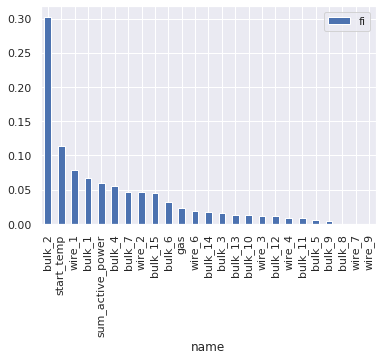

,name,fi
0,bulk_2,0.302488
1,start_temp,0.113946
2,wire_1,0.078847
3,bulk_1,0.066405
4,sum_active_power,0.059201
5,bulk_4,0.054984
6,bulk_7,0.047201
7,wire_2,0.046956
8,bulk_15,0.044514
9,bulk_6,0.031349


In [108]:
fi.plot.bar(x='name', y='fi')
plt.show()
fi

<div class="alert alert-info"> <b>Комментарий студента:</b> Мы видим, что последние 3 фактора(bulk_8, wire_7, wire_9) никак не влияют на модель, поэтому их можно убрать. Остальные факторы все важны)</div>

## Итоговый вывод

В ходе работы, было выполнено:
- подготовилии данные: заменили пропуски, изменили тип данных и названия столбцов, удалили аномалии;
- объединили данные в одну таблицу;
- выбрали модели и разбили выборку на features(75%) и target(25%);
- обучилии модели;
- протестировали.

Наилучшей моделью оказался CatBoostRegressor с MAE = 5.204 и временем обучения 1min 27s, но, если посмотреть на модель XGBRegressor, она немного уступает в показателе MAE = 5.349, но намного превосходит во времени обучении 14.7 s. Это почти в 6 раз быстрее. У остальных моделей RandomForestRegressor, LGBMRegressor время обучения свыше минуты, а у LinearRegression показатель MAE хуже всех - 6.703948. 

Поэтому лучшей моделью является XGBRegressor.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Илья, скажу, что уверенная работа, на мой взгляд)<br>
Обработка данных, модельная работа, конечные результаты - многое удалось как надо<br> Очень здорово, что сразу ищешь новые фичи, думаешь над ними, анализируешь. Это тот самый подход, который нужен, чтобы искать ту саму модель для заказчика)<br> Осталось лишь несколько вопросов с моей стороны))<br>
  
При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы модели имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее) Этот момент сделан хорошо. Есть ещё один инструмент, который помгает в нашей работе.<br><br>
<font color='red'>      
Попробуй с помощью команды feature_importances_ выводить график важности факторов. Отличная вещь будет: высока яметрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала.
Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют.<br>
    
<font color='green'>
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Просто этот пункт - важный момент в алгоритме моделирования. И хотелось, чтобы он у тебя остался в финале.<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо за подсказки, очень удобно смотреть важность каждого фактора)</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
ОК, Илья. С доработкой - в яблочко)<br>
Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
<font color='green'>
Если остались/появились вопросы - обязательно напиши в следующем спринте, он точно ко мне придёт)<br>
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)

Отчет по решению:

1. Выполнены все пункты плана;
2. Небольшие трудности были с удалением партий, где нет значения последней температуры и где есть только одно измерение температуры. Немного запутался, но потом разобрался. Так же трудности были с удалением аномалий, при помощи KNN, помогла статья: https://www.machinelearningmastery.ru/detecting-and-modeling-outliers-with-pyod-d40590a96488/. И конечно же с подбором параметров, при обучении моделей старался брать не слишком высокие параметры: n_estimators, num_leaves)
3. Ключевые шаги: найти начальную и конечную температуру, объединить таблицы без потери данных, удаление аномалий, мультиколлинеарность помогла удалить две не нужные записи, подобрать такие параметры, чтобы модель обучалась как можно быстрее и правильнее.
4. XGBRegressor - mae = 5.349378, время обучения = 14.7 s.

Тимлид ответил на все вопросы и очень внятно, на понятном языке объяснил, что от меня требуется и как можно улучшить проект. Спасибо вам большое за столь увлекательное путешествие!))


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ ТИМЛИДА</u>
</font>
<font color='green'><br>
Привет Илья!<br>
Спасибо)<br>
Читая о трудностях, могу заключить, что они кааются пониманию бизнес-процессов заказчика. И это так - это наиболее важный и слолжный этап моделирования. Но без этого в нашей работа не обойтись. Можно сказать - вскрывать особенности процессов заказчика - часть нашей работы. Ведь замоделировать можно только то, что понимаешь). <br>
Также, хотел бы отметить твою графическую работу. Она всегда хорошо подкрепляла аналитику. На защите заказчику - хорошая графика - может прибавить дополнительной лояльности. Поэтому, стоит её улублять и дальше. <br>
Если говорить о кодовой части, то тут можно прибавить в написании функций для моделирования, конструкций pipline, классы... Но тут вообще всем нам тяжедело дойти до предела совершенства - всегда есть, что изучать:).<br>
Также замечу, что тебе удалось быстро вникнуть в суть задачи. А это не проcто - понять новую бизнес-задачу. Здорово, что есть такой важный скил.<br>

Далее скажу, что стараюсь говорить всем на финале.<br>
Пройден большой путь. Со своими коcогорами и равнинами, медианами и дисперсиями)<br>
Умение аналитически мыслить, писать красивый код, эффективно автоматизировать расчёты, видеть задачи бизнеса через призму моделирования - вот то основное, что  останется у тебя важного после нашей школы. А дальше - только взращивать посеянные зёрна и укреплять свои скилы.<br><br>
Если говорить о развитии дополнительных компетенций, рекомендовал бы ещё глянуть такие области знаний:<br>
1) Организация проектов по проведению моделирования (например Методология CRISP-DM (Cross-Industry Standard Process)<br>
2) Умения системно подходить к решению аналитической задачи. (например методология ТРИЗ, системный анализ)<br>
3) Если в промышленности будут проекты, то рекоммендовал бы освоить  "Статистичекий контроль качества (SPC)"<br>
4) Ещё важный навык: перевод результататов моделирования на язык бизнеса. Т.е. понимание, как целевые показатели моделей влияют на финансовую выгоду заказчика.<br>
5) Если говорить о модельных рекоммендациях, то есть ещё такие способы как блендинг и стакинг разных моделей.<br><br>

Спасибо!<br>
И УДАЧИ)